In [460]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from glob import glob
from scipy.optimize import least_squares
from skimage.filters import gabor_kernel, threshold_otsu, window
from scipy import ndimage as ndi
from skimage.measure import regionprops
from scipy.fft import fft2, fftshift, rfft2, rfftfreq, fftfreq
from skimage.io import imread
from pathlib import Path
from matplotlib import rc

In [180]:
nobands = np.array(Image.open(r'/home/brandon/Downloads/tiffany_test_image2.tif'))
bands = np.array(Image.open(r'/home/brandon/Downloads/tiffany_test_image.tif'))


In [181]:
plt.figure()
plt.imshow(bands)

In [57]:
im2 = bands.copy()
im2[im2 < 400] = 0
line_dist = np.sum(im2, axis=0)
plt.figure()
plt.plot(line_dist)


In [60]:
%matplotlib inline

In [7]:
def autocorr(x, lags):
    corr = np.zeros(len(lags))
    for i in range(len(lags)):
        l = lags[i]
        if l == 0:
            corr[i] = 1
        else:
            a = x[l:]
            b = x[:-l]
            corr[i] = (np.mean(a * b) - np.mean(a) * np.mean(b)) / np.std(a) / np.std(b)

    return corr


def auto_corr_fit_func(t, correlation_time, period, amplitude):
    y = amplitude * np.exp(-t / correlation_time) * np.cos(t * 2 * np.pi / period)

    return y


def fit_auto_corr(corrs, lags, timestep):
    # time in minutes for this --- need to make this consistent
    params = [11.0, 40.0, 1.0]
    error_function = lambda p: auto_corr_fit_func(lags * timestep, p[0], p[1], p[2]) - corrs
    result = least_squares(error_function, params, bounds=([10.0, 0, 0], [180, 80.0, 1.5]))

    return result.x

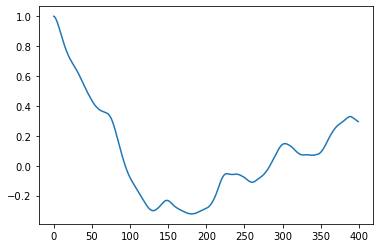

In [8]:
lags = np.arange(0, 400)
ac = autocorr(line_dist, lags)
plt.figure()
plt.plot(lags, ac)

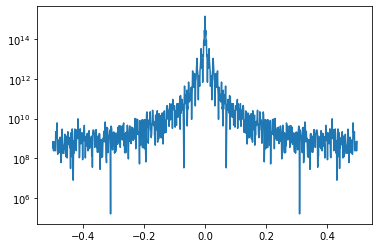

In [14]:
ps = np.abs(np.fft.fft(line_dist))**2

time_step = 1
freqs = np.fft.fftfreq(line_dist.size, time_step)
idx = np.argsort(freqs)

plt.figure()
plt.plot(freqs[idx], ps[idx])
plt.yscale('log')

In [12]:
len(line_dist)

906

In [13]:
1/ 906

0.0011037527593818985

In [101]:
frequency = 1 / 70
theta = 0.0
sigma = 1.0
kernel = np.real(gabor_kernel(frequency, theta=theta,
                                          sigma_x=sigma, sigma_y=sigma))

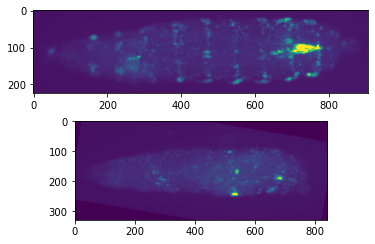

In [102]:
plt.figure()
filt = ndi.convolve(bands, np.real(kernel), mode='wrap')
plt.subplot(2,1,1)
plt.imshow(filt, vmin=0, vmax=3230)
filt = ndi.convolve(nobands, np.real(kernel), mode='wrap')
plt.subplot(2,1,2)
plt.imshow(filt, vmin=0, vmax=3230)


In [182]:
1/ 90

0.011111111111111112

In [179]:
plt.figure()
plt.subplot(2,1,1)
plt.imshow(bands, vmin=0, vmax=3230)
plt.subplot(2,1,2)
plt.imshow(nobands, vmin=0, vmax=3230)


In [106]:
def crop_larvae(im, thresh=250):
    mask = im > thresh
    regions = regionprops(mask.astype('uint8'))
    areas = [region.area for region in regions]
    big_region = regions[np.where(areas == np.max(areas))[0][0]]
    ymin, xmin, ymax, xmax = big_region.bbox
    crop = im[ymin:ymax, xmin:xmax]
    
    return crop

def windowed_fft(image):
    wimage = image * window('hann', image.shape)
    wimage_f = np.abs(fftshift(fft2(wimage)))
    
    return wimage_f

def compute_upper_to_core_ratio(freqs):
    sy, sx = freqs.shape
    center_x = sx // 2
    center_y = sy // 2
    freq_width_x = 40
    delta_fy = 10
    core = freqs[center_y - delta_fy: center_y + delta_fy, center_x - freq_width_x:center_x + freq_width_x]
    upper = freqs[center_y + delta_fy: center_y + 2 * delta_fy, center_x - freq_width_x:center_x + freq_width_x]
    lower = freqs[center_y - 2 * delta_fy: center_y - delta_fy, center_x - freq_width_x:center_x + freq_width_x]
    
    ratio = np.sum(upper) / np.sum(core)
    
    return ratio


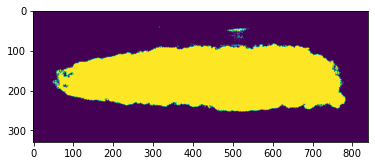

In [24]:
plt.imshow(nobands > 250)

In [168]:
im = nobands
thresh = 250
crop = crop_larvae(im)


In [169]:
plt.figure()
plt.imshow(crop > 650)

In [58]:
%matplotlib qt

In [170]:
# compare fft for bands and no bands

plt.figure()

# nobands
im = nobands
crop = crop_larvae(im)
ft = windowed_fft(crop)
freqs_y = fftfreq(n=crop.shape[0])
freqs_x = fftfreq(n=crop.shape[1])
plt.subplot(121)
#plt.imshow(np.log10(ft), vmin=3, vmax=6)
plt
xticks = np.array([len(freqs_x) // 2 - len(freqs_x) // 4, len(freqs_x) // 2, len(freqs_x) // 2 + len(freqs_x) // 4])
yticks = np.array([len(freqs_y) // 2 - len(freqs_y) // 4, len(freqs_y) // 2, len(freqs_y) // 2 + len(freqs_y) // 4])
plt.xticks(xticks, labels=np.sort(freqs_x)[xticks])
plt.yticks(yticks, labels=np.sort(freqs_y)[yticks])

# bands
im = bands
crop = crop_larvae(im)
crop[crop < 650] = 0
ft = windowed_fft(crop)
plt.subplot(122)
#plt.imshow(np.log10(ft), vmin=3, vmax=6)
plt.imshow(ft)


In [196]:
plt.figure()

# nobands
im = nobands
crop = crop_larvae(im)
crop = crop > 650
ft = windowed_fft(crop)
freqs_y = fftfreq(n=crop.shape[0])
freqs_x = fftfreq(n=crop.shape[1])
plt.subplot(121)
#plt.imshow(np.log10(ft), vmin=5, vmax=8)
plt.imshow(np.log10(ft) > 2.5)

#plt.imshow(ft)
#plt.xlim([ft.shape[1] // 2 - 10, ft.shape[1] // 2 + 10])
#plt.ylim([ft.shape[0] // 2 - 10, ft.shape[0] // 2 + 10])
#xticks = np.array([len(freqs_x) // 2 - len(freqs_x) // 4, len(freqs_x) // 2, len(freqs_x) // 2 + len(freqs_x) // 4])
#yticks = np.array([len(freqs_y) // 2 - len(freqs_y) // 4, len(freqs_y) // 2, len(freqs_y) // 2 + len(freqs_y) // 4])
#plt.xticks(xticks, labels=np.sort(freqs_x)[xticks])
#plt.yticks(yticks, labels=np.sort(freqs_y)[yticks])
ft_no = ft

im = bands
crop = crop_larvae(im)
crop = crop > 650
ft = windowed_fft(crop)
plt.subplot(122)
#plt.imshow(np.log10(ft), vmin=5, vmax=8)
plt.imshow(np.log10(ft) > 2.5)
#plt.imshow(ft)
#plt.xlim([ft.shape[1] // 2 - 10, ft.shape[1] // 2 + 10])
#plt.ylim([ft.shape[0] // 2 - 10, ft.shape[0] // 2 + 10])

In [193]:
plt.figure()
im = nobands
crop = crop_larvae(im)
crop = crop > 650
plt.subplot(121)
plt.imshow(crop)
im = bands
crop = crop_larvae(im)
crop = crop > 650
plt.subplot(122)
plt.imshow(crop)

In [185]:
plt.figure()
zoomin = ft[(ft.shape[0] // 2 - 10):(ft.shape[0] // 2 + 10), (ft.shape[1] // 2 - 10):(ft.shape[1] // 2 + 10)]
zoomin_no = ft_no[(ft_no.shape[0] // 2 - 10):(ft_no.shape[0] // 2 + 10), (ft_no.shape[1] // 2 - 10):(ft_no.shape[1] // 2 + 10)]
plt.imshow(zoomin - zoomin_no, vmin=0)

In [114]:
np.sort(freqs_x)

array([-0.49931973, -0.49795918, -0.49659864, -0.4952381 , -0.49387755,
       -0.49251701, -0.49115646, -0.48979592, -0.48843537, -0.48707483,
       -0.48571429, -0.48435374, -0.4829932 , -0.48163265, -0.48027211,
       -0.47891156, -0.47755102, -0.47619048, -0.47482993, -0.47346939,
       -0.47210884, -0.4707483 , -0.46938776, -0.46802721, -0.46666667,
       -0.46530612, -0.46394558, -0.46258503, -0.46122449, -0.45986395,
       -0.4585034 , -0.45714286, -0.45578231, -0.45442177, -0.45306122,
       -0.45170068, -0.45034014, -0.44897959, -0.44761905, -0.4462585 ,
       -0.44489796, -0.44353741, -0.44217687, -0.44081633, -0.43945578,
       -0.43809524, -0.43673469, -0.43537415, -0.43401361, -0.43265306,
       -0.43129252, -0.42993197, -0.42857143, -0.42721088, -0.42585034,
       -0.4244898 , -0.42312925, -0.42176871, -0.42040816, -0.41904762,
       -0.41768707, -0.41632653, -0.41496599, -0.41360544, -0.4122449 ,
       -0.41088435, -0.40952381, -0.40816327, -0.40680272, -0.40

In [123]:
len(freqs_x) // 2

367

In [124]:
np.sort(freqs_x)[367]

0.0

In [75]:
im = bands
crop = crop_larvae(im)
freqs = windowed_fft(crop)

In [81]:
sy, sx = freqs.shape
freq_width_x = 40
center_x = sx // 2
center_y = sy // 2
central_bit = freqs[:, center_x - freq_width_x: center_x + freq_width_x]

In [77]:
plt.figure()
plt.imshow(np.log10(central_bit.T))

In [78]:
plt.close('all')

In [97]:
im = bands
crop = crop_larvae(im)
freqs = windowed_fft(crop)
sy, sx = freqs.shape
center_x = sx // 2
center_y = sy // 2
freq_width_y = 40
freq_width_x = 40
delta_fy = 10
core = freqs[center_y - delta_fy: center_y + delta_fy, center_x - freq_width_x:center_x + freq_width_x]
upper = freqs[center_y + delta_fy: center_y + 2 * delta_fy, center_x - freq_width_x:center_x + freq_width_x]
lower = freqs[center_y - 2 * delta_fy: center_y - delta_fy, center_x - freq_width_x:center_x + freq_width_x]

np.sum(upper) / np.sum(core)

0.17540688598205553

In [96]:
plt.figure()
plt.imshow(np.log10(upper))

In [89]:
center_y

96

In [93]:
sy

193

In [99]:
ratio = compute_upper_to_core_ratio(freqs)

In [100]:
ratio

0.17540688598205553

In [139]:
%matplotlib qt

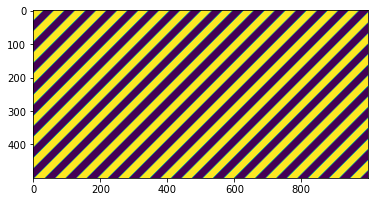

In [295]:
# test images
ygrid, xgrid = np.indices((500, 1000))
test_im = np.sin(xgrid / 10 + ygrid / 10)
test_im = test_im > 0
plt.figure()
plt.imshow(test_im)

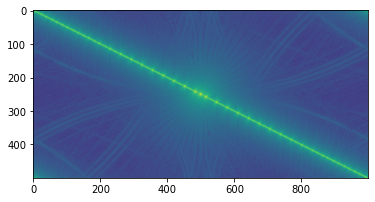

In [296]:
ft = windowed_fft(test_im)
plt.figure()
plt.imshow(np.log10(ft))
#freqs_y = fftfreq(n=test_im.shape[0])
#freqs_x = fftfreq(n=test_im.shape[1])
##xticks = np.array([len(freqs_x) // 2 - len(freqs_x) // 4, len(freqs_x) // 2, len(freqs_x) // 2 + len(freqs_x) // 4])
#yticks = np.array([len(freqs_y) // 2 - len(freqs_y) // 4, len(freqs_y) // 2, len(freqs_y) // 2 + len(freqs_y) // 4])
#plt.xticks(xticks, labels=np.sort(freqs_x)[xticks])
#plt.yticks(yticks, labels=np.sort(freqs_y)[yticks])

In [183]:
freqs_x

array([ 0.        ,  0.00179533,  0.00359066,  0.005386  ,  0.00718133,
        0.00897666,  0.01077199,  0.01256732,  0.01436266,  0.01615799,
        0.01795332,  0.01974865,  0.02154399,  0.02333932,  0.02513465,
        0.02692998,  0.02872531,  0.03052065,  0.03231598,  0.03411131,
        0.03590664,  0.03770197,  0.03949731,  0.04129264,  0.04308797,
        0.0448833 ,  0.04667864,  0.04847397,  0.0502693 ,  0.05206463,
        0.05385996,  0.0556553 ,  0.05745063,  0.05924596,  0.06104129,
        0.06283662,  0.06463196,  0.06642729,  0.06822262,  0.07001795,
        0.07181329,  0.07360862,  0.07540395,  0.07719928,  0.07899461,
        0.08078995,  0.08258528,  0.08438061,  0.08617594,  0.08797127,
        0.08976661,  0.09156194,  0.09335727,  0.0951526 ,  0.09694794,
        0.09874327,  0.1005386 ,  0.10233393,  0.10412926,  0.1059246 ,
        0.10771993,  0.10951526,  0.11131059,  0.11310592,  0.11490126,
        0.11669659,  0.11849192,  0.12028725,  0.12208259,  0.12

In [184]:
1 / 90

0.011111111111111112

In [186]:
231-157


74

In [187]:
1 / 74

0.013513513513513514

In [200]:
ft.shape

(500, 1000)

In [254]:
mask = ft > 1e3
plt.figure()
plt.imshow(mask)

In [255]:
regions = regionprops(mask.astype("uint8"))

In [256]:
regions[0].eccentricity

0.0

In [244]:
im = nobands
crop = crop_larvae(im)
crop = crop > 250#650
ft = windowed_fft(crop)
mask = ft > 316
plt.figure()
plt.imshow(mask)
region = regionprops(mask.astype('uint8'))[0]
xlength = region.major_axis_length * np.sin(region.orientation)
print(region.eccentricity)
print(xlength)

0.9433749263451027
3.7349769868932974


In [240]:
10 ** 2.5

316.22776601683796

In [225]:
regionprops(mask.astype('uint8'))[0].major_axis_length

59.028703265273016

In [229]:
plt.figure()
plt.imshow(crop)

# Run on batches of data

In [264]:
control_path = r'/media/brandon/Data1/Tiffany/AxioZoom/Experimental Data/2023_6_24_hmlgfp_controls/Rotated Control'
bacteria_15hr_path = r'/media/brandon/Data1/Tiffany/AxioZoom/Experimental Data/2023_6_30_hmlgfp_ecoli_mag23.5/Rotated15hr'

In [258]:
%matplotlib inline

In [278]:
x_window = 100
y_window = 50

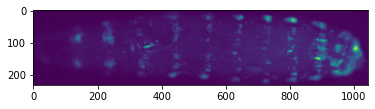

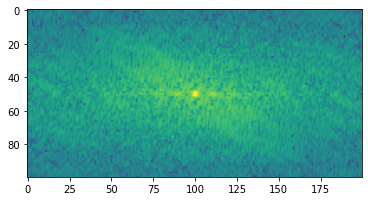

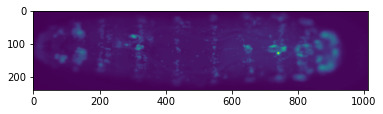

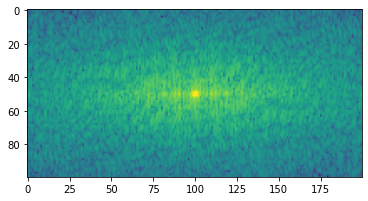

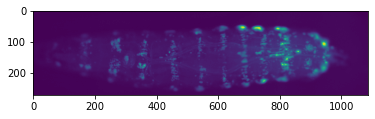

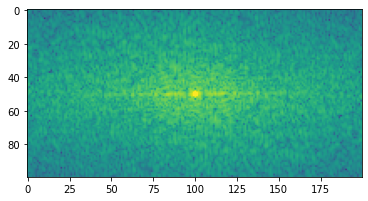

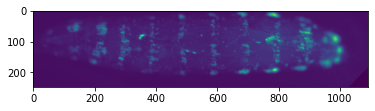

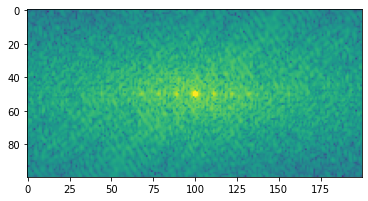

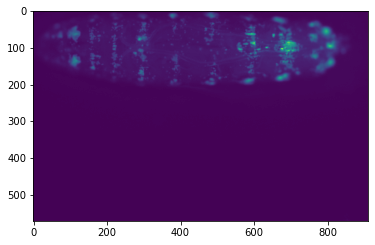

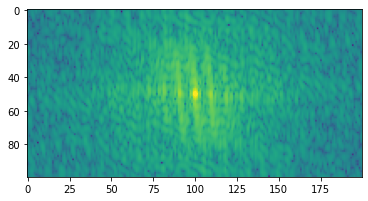

In [309]:
files = glob(control_path + '/*.tif')
for file in files:
    im = imread(file)
    crop = crop_larvae(im)
    plt.figure()
    plt.imshow(crop)
    ft = windowed_fft(crop)
    center_y = ft.shape[0] // 2
    center_x = ft.shape[1] // 2
    
    ft_zoom = ft[center_y - y_window: center_y + y_window, center_x - x_window:center_x + x_window]
    plt.figure()
    plt.imshow(np.log10(ft_zoom), vmin=2, vmax=7)


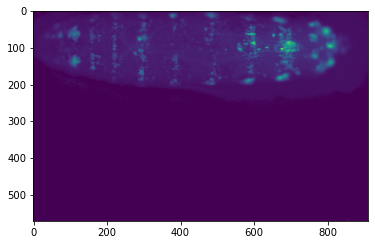

In [302]:
plt.figure()
crop[crop < 200] = 0
plt.imshow(crop)

# Trying Tiffany's intersection metric

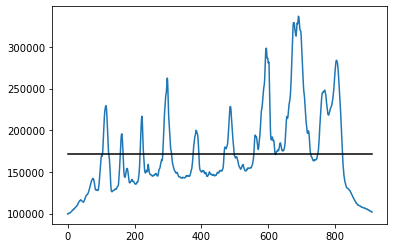

In [310]:
crop_1d = np.sum(crop, axis=0)
plt.figure()
plt.plot(crop_1d)
crop_1d_mean = np.mean(crop_1d)
xline = np.arange(0, len(crop_1d))
plt.plot(xline, crop_1d_mean * np.ones_like(xline), 'k-')

In [304]:
files = glob(bacteria_15hr_path + '/*.tif')
for file in files:
    im = imread(file)
    crop = crop_larvae(im)
    crop[crop < 200] = 0
    crop_1d = np.sum(crop, axis=0)
    crop_1d_mean = np.mean(crop_1d)
    plt.figure()
    plt.imshow(crop)
    ft = windowed_fft(crop)
    center_y = ft.shape[0] // 2
    center_x = ft.shape[1] // 2
    
    ft_zoom = ft[center_y - y_window: center_y + y_window, center_x - x_window:center_x + x_window]
    plt.figure()
    plt.imshow(np.log10(ft_zoom), vmin=2, vmax=7)


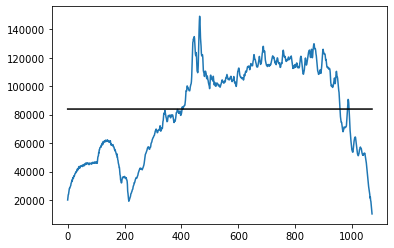

In [307]:
plt.figure()
crop[crop < 200] = 0
crop_1d = np.sum(crop, axis=0)
plt.plot(crop_1d)
crop_1d_mean = np.mean(crop_1d)
xline = np.arange(0, len(crop_1d))
plt.plot(xline, crop_1d_mean * np.ones_like(xline), 'k-')

In [315]:
files = glob(bacteria_15hr_path + '/*.tif')
n_intersections_bacteria = []
for i, file in enumerate(files):
    im = imread(file)
    crop = crop_larvae(im)
    crop[crop < 200] = 0
    crop_1d = np.sum(crop, axis=0)
    crop_1d_mean = np.mean(crop_1d)
    xline = np.arange(0, len(crop_1d))
    yline = crop_1d_mean * np.ones_like(xline)
    
    # find intersections of 1d dist and a horizontal line at the mean
    idx = np.argwhere(np.diff(np.sign(crop_1d - yline))).flatten()
    n_intersections_bacteria.append(len(idx))
    

In [316]:
n_intersections_bacteria

[4, 10, 6, 4, 10, 6, 8, 12, 8, 22, 8]

In [317]:
files = glob(control_path + '/*.tif')
n_intersections_control = []
for i, file in enumerate(files):
    im = imread(file)
    crop = crop_larvae(im)
    crop[crop < 200] = 0
    crop_1d = np.sum(crop, axis=0)
    crop_1d_mean = np.mean(crop_1d)
    xline = np.arange(0, len(crop_1d))
    yline = crop_1d_mean * np.ones_like(xline)
    
    # find intersections of 1d dist and a horizontal line at the mean
    idx = np.argwhere(np.diff(np.sign(crop_1d - yline))).flatten()
    n_intersections_control.append(len(idx))

In [318]:
n_intersections_control

[18, 16, 14, 20, 16]

Text(0, 0.5, 'number of intersections with mean line')

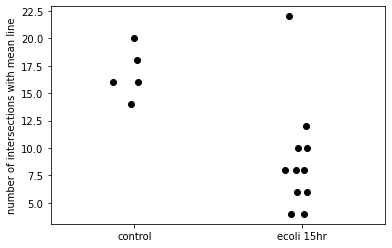

In [328]:
# plot dot plot of number of intersections
plt.figure()
sigma_x = 0.05
# control
xid = 0
n_intersections = n_intersections_control
plt.plot(xid * np.ones(len(n_intersections)) + sigma_x * np.random.normal(size=len(n_intersections)), n_intersections , 'ko')

# bacteria
xid = 1
n_intersections = n_intersections_bacteria
plt.plot(xid * np.ones(len(n_intersections)) + sigma_x * np.random.normal(size=len(n_intersections)), n_intersections, 'ko')

plt.xlim([-0.5, 1.5])
plt.xticks([0, 1], labels=('control', 'ecoli 15hr'))
plt.ylabel('number of intersections with mean line')

In [380]:
def compute_1d_dist(im, background=200):
    crop = crop_larvae(im)
    crop[crop < background] = 0
    crop_1d = np.sum(crop, axis=0)
    
    return crop_1d


def count_mean_line_intersections(im, background=200):
    crop_1d = compute_1d_dist(im, background=background)
    crop_1d_mean = np.mean(crop_1d)
    xline = np.arange(0, len(crop_1d))
    yline = crop_1d_mean * np.ones_like(xline)
    
    # find intersections of 1d dist and a horizontal line at the mean
    idx = np.argwhere(np.diff(np.sign(crop_1d - yline))).flatten()
    
    return len(idx)



# trying find peaks

In [329]:
from scipy.signal import find_peaks

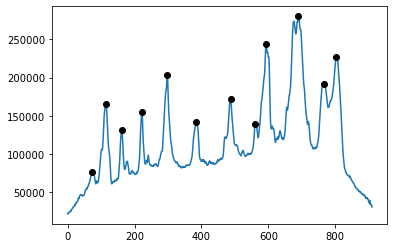

In [342]:
crop_1d = np.array(crop_1d)
peaks = find_peaks(crop_1d, width=8)[0]
plt.figure()
plt.plot(crop_1d)
plt.plot(peaks, crop_1d[peaks], 'ko')

In [336]:
peaks[0]

array([ 74, 114, 298, 385, 487, 594, 690, 766, 803])

In [344]:
files = glob(bacteria_15hr_path + '/*.tif')
n_peaks_bacteria = []
for i, file in enumerate(files):
    im = imread(file)
    crop = crop_larvae(im)
    crop[crop < 200] = 0
    crop_1d = np.sum(crop, axis=0)
    peaks = find_peaks(crop_1d, width=8)[0]
    n_peaks_bacteria.append(len(peaks))


files = glob(control_path + '/*.tif')
n_peaks_control = []
for i, file in enumerate(files):
    im = imread(file)
    crop = crop_larvae(im)
    crop[crop < 200] = 0
    crop_1d = np.sum(crop, axis=0)
    peaks = find_peaks(crop_1d, width=8)[0]
    n_peaks_control.append(len(peaks))


Text(0, 0.5, 'number of peaks')

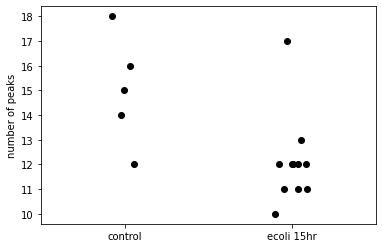

In [345]:
# plot dot plot of number of peaks
plt.figure()
sigma_x = 0.05
# control
xid = 0
n_peaks = n_peaks_control
plt.plot(xid * np.ones(len(n_peaks)) + sigma_x * np.random.normal(size=len(n_peaks)), n_peaks , 'ko')

# bacteria
xid = 1
n_peaks = n_peaks_bacteria
plt.plot(xid * np.ones(len(n_peaks)) + sigma_x * np.random.normal(size=len(n_peaks)), n_peaks, 'ko')

plt.xlim([-0.5, 1.5])
plt.xticks([0, 1], labels=('control', 'ecoli 15hr'))
plt.ylabel('number of peaks')

# plot a bunch of Tiffany's data

In [431]:
ctl_paths = [r'/media/brandon/Data1/Tiffany/AxioZoom/Experimental Data/2023_6_23_hmlgfp_ecoli/Rotatedcontrol', r'/media/brandon/Data1/Tiffany/AxioZoom/Experimental Data/2023_6_24_hmlgfp_controls/Rotated Control']
mock_paths = [r'/media/brandon/Data1/Tiffany/AxioZoom/Experimental Data/2023_8_2_hmlgfp_mockinj_mag23.5_Earlymid/Rotated 95min', r'/media/brandon/Data1/Tiffany/AxioZoom/Experimental Data/2023_8_6_hmlgfp_mockinj_mag23.5_Earlymid/Rotated 90min']
mid_paths = [r'/media/brandon/Data1/Tiffany/AxioZoom/Experimental Data/2023_7_5_hmlgfp_ecoli_mag23.5/Rotated 90min', r'/media/brandon/Data1/Tiffany/AxioZoom/Experimental Data/2023_7_7_hmlgfp_ecoli_mag23.5/Rotated 90']
early_mid_paths = [r'/media/brandon/Data1/Tiffany/AxioZoom/Experimental Data/2023_6_29_hmlgfp_ecoli_mag23.5/4samelarvaeovertime/Rotated80min', r'/media/brandon/Data1/Tiffany/AxioZoom/Experimental Data/2023_6_29_hmlgfp_ecoli_mag23.5/Theother7larvae/Rotated 85min', r'/media/brandon/Data1/Tiffany/AxioZoom/Experimental Data/2023_7_1_hmlgfp_ecoli_mag23.5/Rotated 90']
early_mid_15hr_paths = [r'/media/brandon/Data1/Tiffany/AxioZoom/Experimental Data/2023_6_30_hmlgfp_ecoli_mag23.5/Rotated15hr', r'/media/brandon/Data1/Tiffany/AxioZoom/Experimental Data/2023_7_2_hmlgfp_ecoli_mag23.5/Rotated 15hr']
early_mid_mock_15hr_paths = [r'/media/brandon/Data1/Tiffany/AxioZoom/Experimental Data/2023_8_2_hmlgfp_mockinj_mag23.5_Earlymid/Rotated 14.5hr', r'/media/brandon/Data1/Tiffany/AxioZoom/Experimental Data/2023_8_6_hmlgfp_mockinj_mag23.5_Earlymid/Rotated 15hr']
early_mid_ether_control_paths = [r'/media/brandon/Data1/Tiffany/AxioZoom/Experimental Data/2023_6_24_hmlgfp_controls/Rotated Ether Controls']
early_mid_drying_control_paths = [r'/media/brandon/Data1/Tiffany/AxioZoom/Experimental Data/2023_6_24_hmlgfp_controls/Rotated Drying Controls']

In [481]:
def count_intersections_for_all_experiments(paths):
    all_intersections = []
    for path in paths:
        files = glob(path + '/*.tif')
        for file in files:
            im = imread(file)
            cropped_im = crop_larvae(im)
            n_intersections = count_mean_line_intersections(cropped_im)
            all_intersections.append(n_intersections)
            
    return all_intersections

def count_peaks_for_all_experiments(paths):
    all_peaks = []
    for path in paths:
        files = glob(path + '/*.tif')
        for file in files:
            im = imread(file)
            cropped_im = crop_larvae(im)
            dist_1d = compute_1d_dist(cropped_im, background=200)
            peaks = find_peaks(dist_1d, width=8, prominence=30_000)[0]
            all_peaks.append(len(peaks))
            
    return all_peaks

def plot_all_1d_dists(paths, background=200):
    for path in paths:
        files = glob(path + '/*.tif')
        for file in files:
            im = imread(file)
            cropped_im = crop_larvae(im)
            dist_1d = compute_1d_dist(cropped_im, background=background)
            plt.figure()
            plt.plot(dist_1d, 'g-', linewidth=4)
            crop_1d_mean = np.mean(crop_1d)
            xline = np.arange(0, len(crop_1d))
            yline = crop_1d_mean * np.ones_like(xline)
            #plt.plot(xline, yline, 'k-')
            peaks = find_peaks(dist_1d, width=8, prominence=30_000)[0]
            plt.plot(peaks, dist_1d[peaks], 'o', markersize=18, markerfacecolor='none', markeredgecolor='k', markeredgewidth=4)
            plt.title(file)
            plt.xlabel('position along AP axis', fontsize=24)
            plt.ylabel('mean Hml>GFP fluorescence intensity (a.u.)', fontsize=24)
            # style
            rc('axes', linewidth=4)
            fontweight = 'bold'
            fontsize = 24
            ax = plt.gca()
            fontweight = 'bold'
            fontproperties = {'family':'sans-serif','sans-serif':['Arial'],'weight' : fontweight, 'size' : fontsize}
            ax.xaxis.set_tick_params(labelsize=20)
            ax.yaxis.set_tick_params(labelsize=20)
            for tick in ax.xaxis.get_major_ticks():
                tick.label1.set_fontsize(fontsize)
            for tick in ax.yaxis.get_major_ticks():
                tick.label1.set_fontsize(fontsize)

            plt.tight_layout()


In [432]:
# ctl
paths = ctl_paths
all_intersections_ctl = count_intersections_for_all_experiments(paths)
all_peaks_ctl = count_peaks_for_all_experiments(paths)

# mock
paths = mock_paths
all_intersections_mock = count_intersections_for_all_experiments(paths)
all_peaks_mock = count_peaks_for_all_experiments(paths)

# mid
paths = mid_paths
all_intersections_mid = count_intersections_for_all_experiments(paths)
all_peaks_mid = count_peaks_for_all_experiments(paths)

# early_mid
paths = early_mid_paths
all_intersections_early_mid = count_intersections_for_all_experiments(paths)
all_peaks_early_mid = count_peaks_for_all_experiments(paths)

# early_mid_15hr
paths = early_mid_15hr_paths
all_intersections_early_mid_15hr = count_intersections_for_all_experiments(paths)
all_peaks_early_mid_15hr = count_peaks_for_all_experiments(paths)

# early_mid_mock_15hr
paths = early_mid_mock_15hr_paths
all_intersections_early_mid_mock_15hr = count_intersections_for_all_experiments(paths)
all_peaks_early_mid_mock_15hr = count_peaks_for_all_experiments(paths)

# early_mid_drying_1hr
paths = early_mid_drying_control_paths
all_intersections_early_mid_drying_1hr = count_intersections_for_all_experiments(paths)
all_peaks_early_mid_drying_1hr = count_peaks_for_all_experiments(paths)

# early_mid_ether_1hr
paths = early_mid_ether_control_paths
all_intersections_early_mid_ether_1hr = count_intersections_for_all_experiments(paths)
all_peaks_early_mid_ether_1hr = count_peaks_for_all_experiments(paths)


In [397]:
all_peaks_ctl

[13, 15, 13, 14, 14, 14, 14, 14, 11, 14, 18, 16, 15, 12]

In [434]:
len(all_peaks_mock)

22

In [366]:
%matplotlib qt

In [500]:
def plot_n_intersections(n_intersections, xid):
    plt.plot(xid * np.ones(len(n_intersections)) + sigma_x * np.random.normal(size=len(n_intersections)), n_intersections , 'o')
    low, med, high = np.quantile(n_intersections, q=[0.25, 0.5, 0.75])
    xline = np.linspace(xid - 0.1, xid + 0.1, 5)
    low_line = low * np.ones_like(xline)
    high_line = high * np.ones_like(xline)
    xline_med =  np.linspace(xid - 0.25, xid + 0.25, 5)
    med_line = med * np.ones_like(xline_med)
    vert_line_x = xid * np.ones(5)
    vert_line = np.linspace(low, high, len(vert_line_x))
    plt.plot(xline, low_line, 'k-')
    plt.plot(xline, high_line, 'k-')
    plt.plot(xline_med, med_line, 'k-')
    plt.plot(vert_line_x, vert_line, 'k-')
    
def plot_n_peaks(n_peaks, xid):
    plt.plot(xid * np.ones(len(n_peaks)) + sigma_x * np.random.normal(size=len(n_peaks)), n_peaks , 'o', markersize=12, alpha=0.75)
    low, med, high = np.quantile(n_peaks, q=[0.25, 0.5, 0.75])
    xline = np.linspace(xid - 0.1, xid + 0.1, 5)
    low_line = low * np.ones_like(xline)
    high_line = high * np.ones_like(xline)
    xline_med =  np.linspace(xid - 0.25, xid + 0.25, 5)
    med_line = med * np.ones_like(xline_med)
    vert_line_x = xid * np.ones(5)
    vert_line = np.linspace(low, high, len(vert_line_x))
    plt.plot(xline, low_line, 'k-', linewidth=4)
    plt.plot(xline, high_line, 'k-', linewidth=4)
    plt.plot(xline_med, med_line, 'k-', linewidth=4)
    plt.plot(vert_line_x, vert_line, 'k-', linewidth=4)
    

In [490]:
# plot dot plot of number of intersections for all the data
plt.figure()
sigma_x = 0.1

# control
xid = 0
n_intersections = all_intersections_ctl
plot_n_intersections(n_intersections, xid)

# drying control
xid += 1
n_intersections = all_intersections_early_mid_drying_1hr
plot_n_intersections(n_intersections, xid)

# ether control
xid += 1
n_intersections = all_intersections_early_mid_ether_1hr
plot_n_intersections(n_intersections, xid)

# mock 90 min
xid += 1
n_intersections = all_intersections_mock
plot_n_intersections(n_intersections, xid)

# mock 15 hour
xid += 1
n_intersections = all_intersections_early_mid_mock_15hr
plot_n_intersections(n_intersections, xid)

# mid
xid += 1
n_intersections = all_intersections_mid
plot_n_intersections(n_intersections, xid)

# early_mid
xid += 1
n_intersections = all_intersections_early_mid
plot_n_intersections(n_intersections, xid)

# early_mid_15hr
xid += 1
n_intersections = all_intersections_early_mid_15hr
plot_n_intersections(n_intersections, xid)


labels = ('control \n 90min', 'drying control \n 60 min', 'ether control \n 60 min', 'mock \n 90min', 'mock \n 15 hr', 'mid \n 90min', 'early-mid \n 90min', 'early-mid \n ecoli 15hr')

plt.xlim([-0.5, xid + 0.5])
plt.xticks(np.arange(xid+1), labels=labels, fontsize=24)
plt.ylabel('number of intersections with mean line', fontsize=24)
rc('axes', linewidth=4)
fontweight = 'bold'
fontsize = 24
ax = plt.gca()
fontweight = 'bold'
fontproperties = {'family':'sans-serif','sans-serif':['Arial'],'weight' : fontweight, 'size' : fontsize}
ax.xaxis.set_tick_params(labelsize=20)
ax.yaxis.set_tick_params(labelsize=20)
for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize)
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize)

plt.tight_layout()

In [426]:
%matplotlib qt

In [504]:
# plot dot plot of number of peaks for all the data
plt.figure()
sigma_x = 0.1

# control
xid = 0
n_peaks = all_peaks_ctl
plot_n_peaks(n_peaks, xid)

# drying control
xid += 1
n_peaks = all_peaks_early_mid_drying_1hr
plot_n_peaks(n_peaks, xid)

# ether control
xid += 1
n_peaks = all_peaks_early_mid_ether_1hr
plot_n_peaks(n_peaks, xid)

# mock 90 min
xid += 1
n_peaks = all_peaks_mock
plot_n_peaks(n_peaks, xid)

# mock 15 hour
xid += 1
n_peaks = all_peaks_early_mid_mock_15hr
plot_n_peaks(n_peaks, xid)

# # mid
# xid += 1
# n_peaks = all_peaks_mid
# plot_n_peaks(n_peaks, xid)

# early_mid
xid += 1
n_peaks = all_peaks_early_mid
plot_n_peaks(n_peaks, xid)

# early_mid_15hr
xid += 1
n_peaks = all_peaks_early_mid_15hr
plot_n_peaks(n_peaks, xid)


labels = ('control', 'drying control \n 60 min', 'ether control \n 60 min', 'mock injection \n 90min', 'mock injection \n 15 hr', 'e. coli \n 90min', 'ecoli \n 15hr')

plt.xlim([-0.5, xid + 0.5])
plt.xticks(np.arange(xid+1), labels=labels, fontsize=24)
plt.ylabel('number of peaks', fontsize=24)
rc('axes', linewidth=4)
fontweight = 'bold'
fontsize = 24
ax = plt.gca()
fontweight = 'bold'
fontproperties = {'family':'sans-serif','sans-serif':['Arial'],'weight' : fontweight, 'size' : fontsize}
ax.xaxis.set_tick_params(labelsize=20)
ax.yaxis.set_tick_params(labelsize=20)
for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize)
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize)

plt.tight_layout()

In [507]:
plt.savefig(r'/media/brandon/Data1/Tiffany/AxioZoom/plots/early-mid_peak_dot_plots.png')

In [377]:
len(labels)

8

In [361]:
all_intersections_ctl
low, med, high = np.quantile(all_intersections_ctl, q=[0.25, 0.5, 0.75])


In [363]:
med

16.0

In [365]:
all_intersections_ctl

[12, 16, 24, 22, 16, 14, 16, 16, 18, 18, 16, 14, 20, 16]

In [441]:
%matplotlib qt

/tmp/ipykernel_665701/1981333106.py:33: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


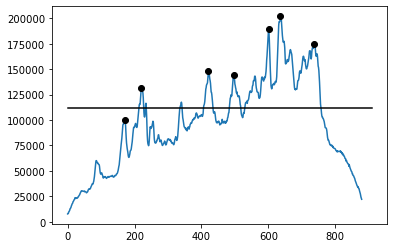

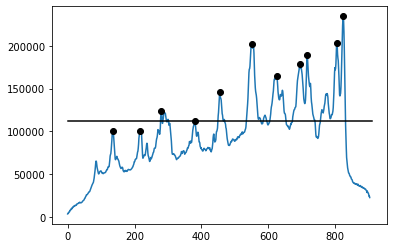

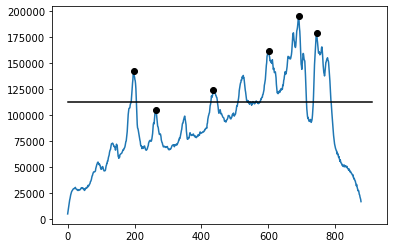

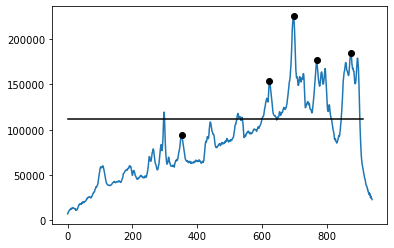

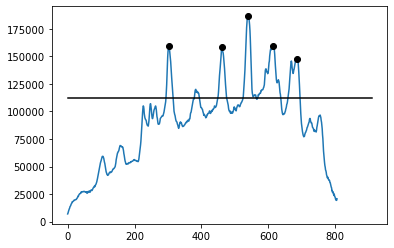

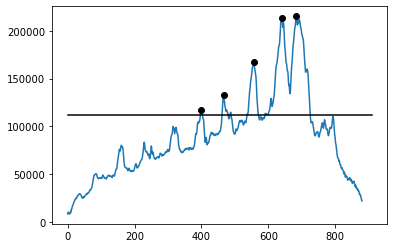

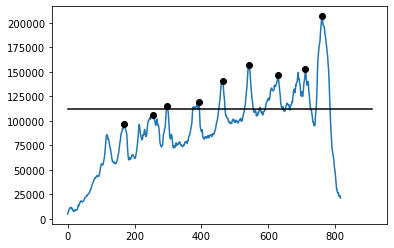

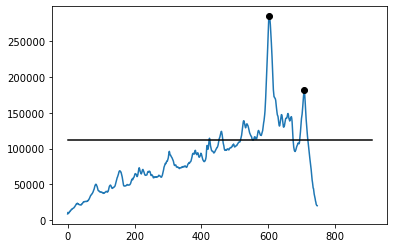

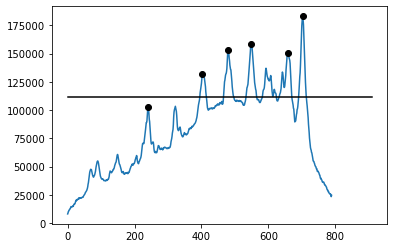

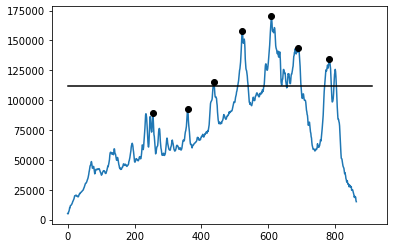

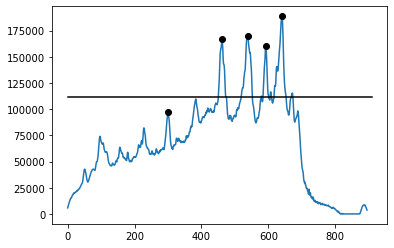

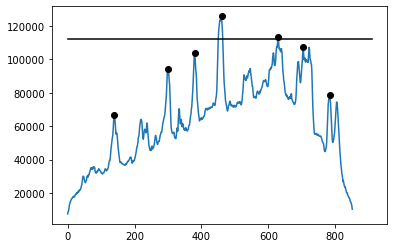

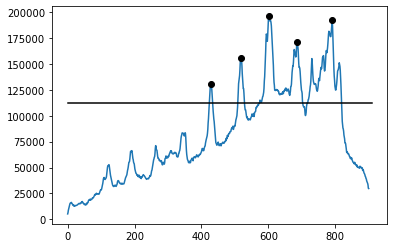

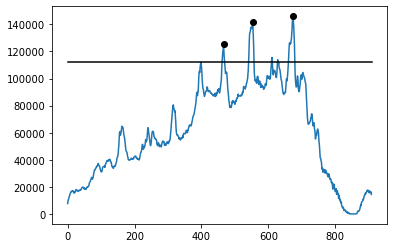

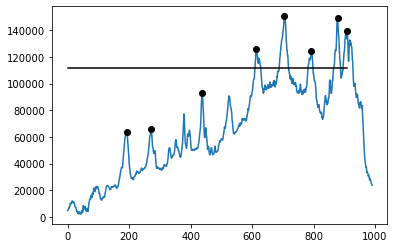

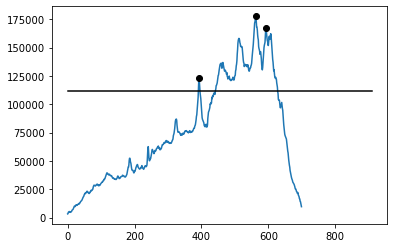

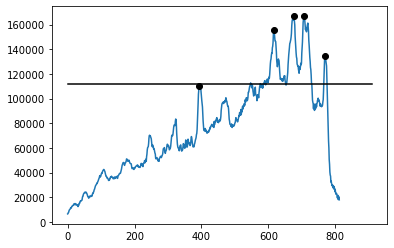

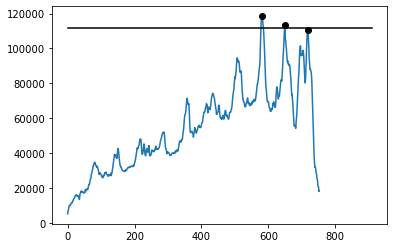

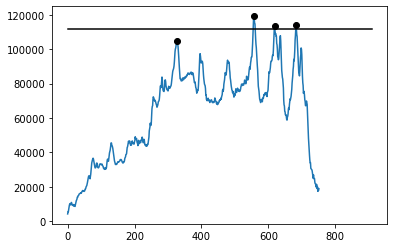

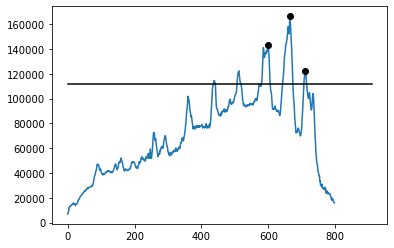

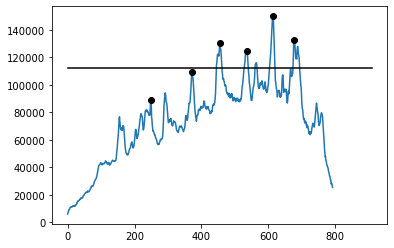

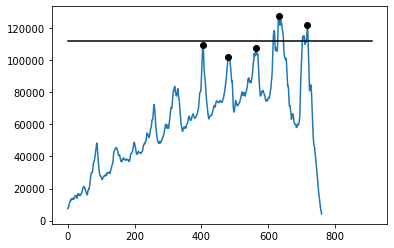

In [423]:
# plot some example 1d dists
paths = early_mid_mock_15hr_paths
plot_all_1d_dists(paths, background=200)

In [508]:
# plot some example 1d dists
paths = early_mid_15hr_paths
plot_all_1d_dists(paths, background=200)


/tmp/ipykernel_665701/2962588389.py:33: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


In [483]:
# plot some example 1d dists
paths = ctl_paths
plot_all_1d_dists(paths, background=200)

/tmp/ipykernel_665701/1981333106.py:33: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


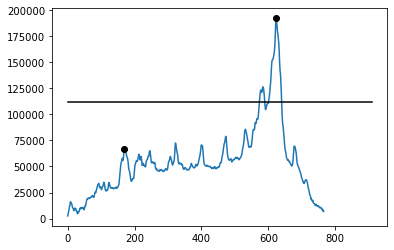

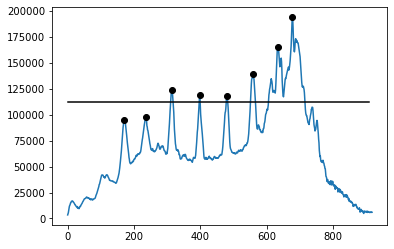

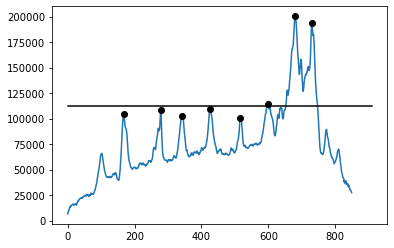

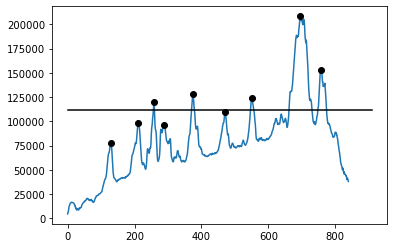

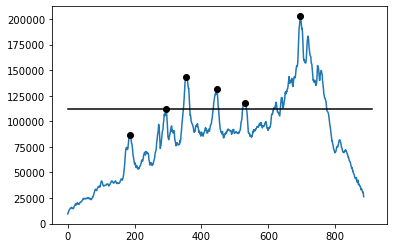

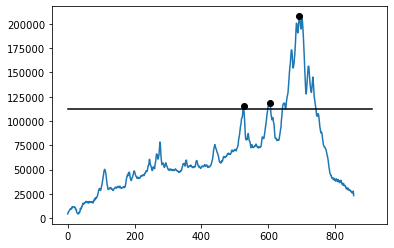

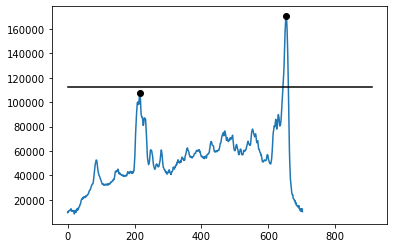

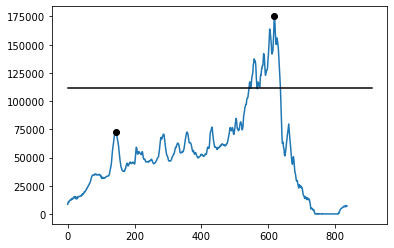

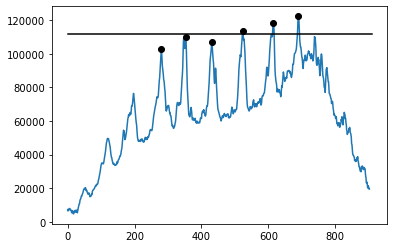

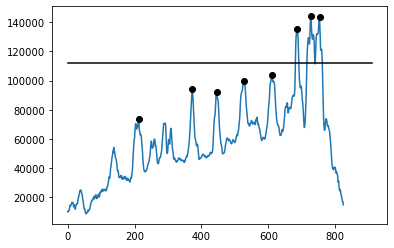

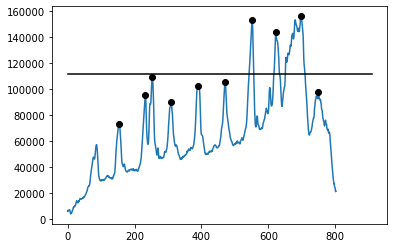

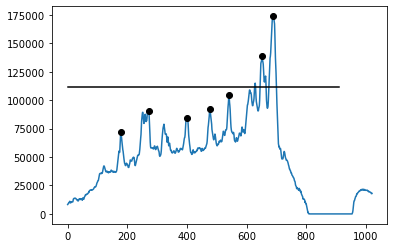

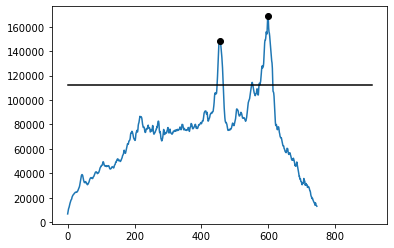

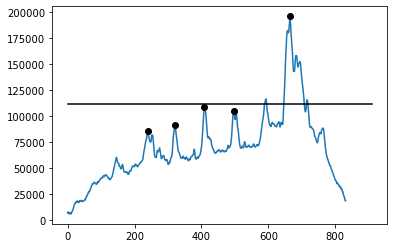

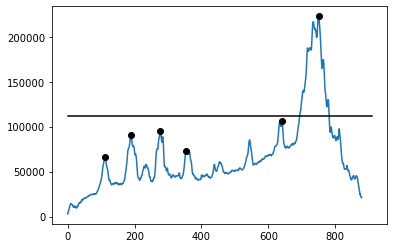

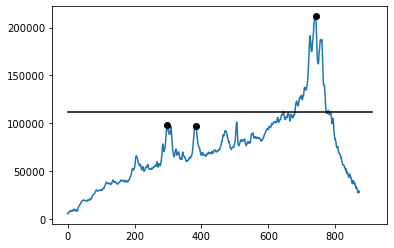

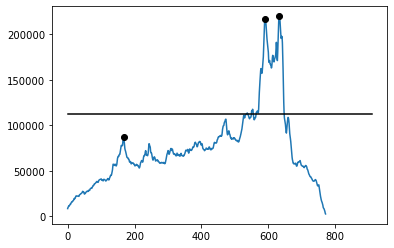

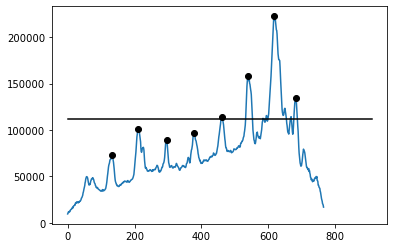

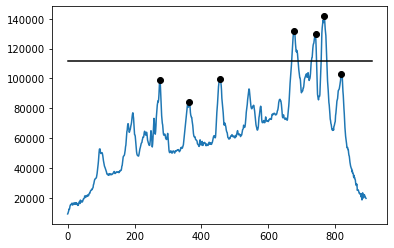

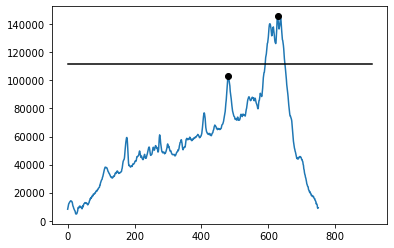

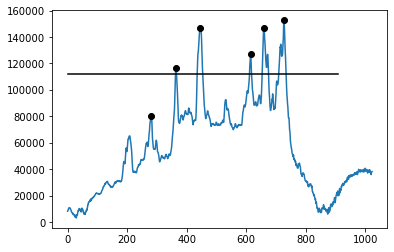

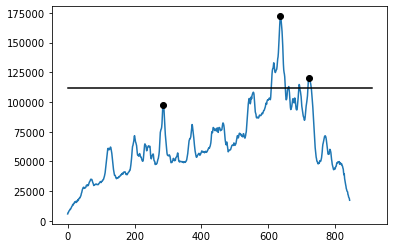

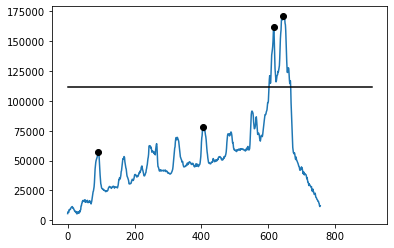

In [437]:
# plot some example 1d dists
paths = early_mid_paths
plot_all_1d_dists(paths, background=200)

In [450]:
Path(file).parent.parent.name + 

'2023_6_24_hmlgfp_controls'

In [482]:
plt.close('all')

In [510]:
plt.xlabel("position along AP axis (pixels)", fontsize=24)

Text(0.5, 47.999999999999986, 'position along AP axis (pixels)')

In [512]:
plt.savefig(r'/media/brandon/Data1/Tiffany/AxioZoom/plots/example_1d_dist_with_peaks_ecoli15hr.png')

In [509]:
plt.title('')

Text(0.5, 1.0, '')